In [95]:
import math
import os

import torch
from torchtext.vocab import build_vocab_from_iterator
from torch import nn, Tensor
from tempfile import TemporaryDirectory
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from typing import Tuple

from sklearn.neighbors import kneighbors_graph
from tqdm.notebook import tqdm, trange
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
class Dataset():
    def __iter__(self):
        for genre in ['ballads', 'elegies', 'songs', 'novels']:
            for file in os.listdir('../datasets/lemmatized/' + genre):
                with open('../datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    yield f.read().split()

In [4]:
def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    data = [torch.tensor(vocab(item), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

In [5]:
def batchify(data: Tensor, bsz: int) -> Tensor:
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
sentences = Dataset()
vocab = build_vocab_from_iterator(sentences)

In [70]:
data = data_process(sentences)
data = batchify(data, bsz=20)

In [9]:

def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape ``[full_seq_len, batch_size]``
        i: int

    Returns:
        tuple (data, target), where data has shape ``[seq_len, batch_size]`` and
        target has shape ``[seq_len * batch_size]``
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [10]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of ``-inf``, with zeros on ``diag``."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [11]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [12]:
bptt = 35 #
ntokens = len(vocab)  # size of vocabulary
emsize = 128  # embedding dimension
d_hid = 128  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [13]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model, train_data) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(trange(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        seq_len = data.size(0)
        if seq_len != bptt:  # only on last batch
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

In [14]:
best_val_loss = float('inf')
epochs = 3

In [ ]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, data)
    scheduler.step()

In [99]:
def getvec(sentence):
    model.eval();
    with torch.no_grad():    
        src = torch.tensor(vocab(sentence), dtype=torch.long)[:, None]
        src = model.encoder(src) * math.sqrt(model.d_model)
        src = model.pos_encoder(src)
        src_mask = generate_square_subsequent_mask(bptt).to(device)
        output = model.transformer_encoder(src, src_mask)
    return output[:, 0, :]

In [100]:
graphs = []
for sentence in sentences:
    if not sentence:
        continue
    adj = kneighbors_graph(getvec(sentence), n_neighbors=5, metric='minkowski', p=2)
    graph = nx.from_scipy_sparse_array(adj)
    mapping = {i: token for i, token in enumerate(sentence)}
    graph = nx.relabel_nodes(graph, mapping)
    graph.remove_edges_from(nx.selfloop_edges(graph))
    graphs.append(graph)
    break

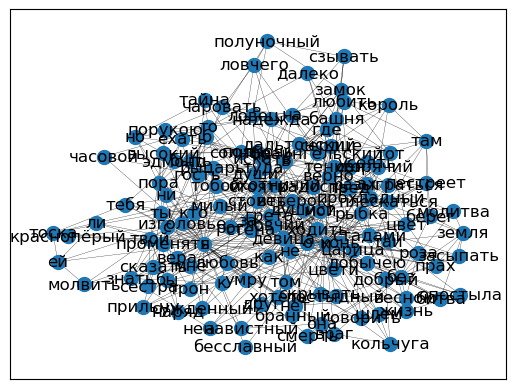

In [101]:
nx.draw_networkx(graphs[0], node_size=100, width=0.2)